In [ ]:
pip install opendatasets

Import the data from Kaggle

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/shenba/time-series-datasets/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sachinsd
Your Kaggle Key: ··········


100%|██████████| 19.2k/19.2k [00:00<00:00, 21.3MB/s]

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('time-series-datasets/Electric_Production.csv',index_col='DATE',parse_dates=True)

In [ ]:
data.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


<Axes: xlabel='DATE'>

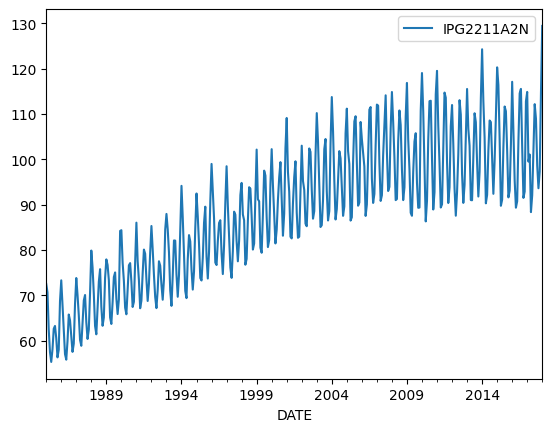

In [ ]:
data.plot()

**Data Pre-Process**

Time Series data needs to arranged in Sliding Window format for training. So that, all the values (except last) in the Window are taken as X, and the value at the next timestep (last element of Window) is taken as Y. So We make as many sliding windows as possible for training.

In [ ]:
winSize = 12
nFeatures = 1 #Here the Data is single variable only

In [ ]:
train = data.copy()

Scale the Data (normalize) since we are using RNN

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
trainScaled = scaler.fit_transform(train)

In [ ]:
# A function to extract data in sliding windows

def slidingWindow( data, winSize):
  Xtrain = []
  ytrain = []
  for i in range( winSize, len(data) ):
    # Here i points to end of Window at each iteration, So minus it by winSize to go to start of window
    Xtrain.append( data[i-winSize:i] ) #Note, this will select all elements as X except last element i because of slicing
    ytrain.append( data[i] ) # Make ith(end of window) element as Y instance values
  return np.array(Xtrain), np.array(ytrain) # Convert them to np arrays since torch uses that

In [ ]:
X , y = slidingWindow(trainScaled , winSize)

In [ ]:
# Print Sample data format
print( f" Given Time series X values :\n {X[0].flatten()}" )
print( f" The next Time Step value Y is : {y[0]} ")

 Given Time series X values :
 [0.23201741 0.20727443 0.09630353 0.02910391 0.         0.03745865
 0.09859805 0.10707831 0.07112325 0.0135012  0.03624525 0.18085375]
 The next Time Step value Y is : [0.24282188] 


**Make Train, Test Split:**

We use last 3 windows data as test, all previous of it as Training data

In [ ]:
trainSize = len(train) - winSize*3

testSize = len(train) - trainSize

In [ ]:
import torch

In [ ]:
Xtrain = torch.tensor( np.array( X[:trainSize] ) , requires_grad = True)
ytrain = torch.tensor( np.array( y[:trainSize] ) , requires_grad = True)

Xtest = torch.tensor( np.array( X[testSize:] ) , requires_grad = True)
ytest = torch.tensor( np.array( y[testSize:] ) , requires_grad = True)

In [ ]:
Xtrain.size()

torch.Size([361, 12, 1])

In [ ]:
import torch
from torch import nn
import torch.functional as F

**LSTM Architecture Define**

Note that in LSTM,

input_size is the number of features of X,
hidden_size is the number of neurons in hidden layer
num_layers is the number of hidden layers.

Also Since the dimension of our data is of the form (batch_size i.e number of windows , seq_size i.e window size, number of features)
instead of the standard (seq_size, batch_size, no of features), We need to give option **batch_first = True**
# ---------------------------------------------------------------------

Note : The fully connected layers, dense layers (also known as fully connected layers) are used after the LSTM layer for several reasons:

Dimensionality Reduction: LSTM outputs may have a high dimensionality, which can be reduced to a manageable size using fully connected layers.

Feature Extraction: While LSTM layers capture temporal dependencies well, they may not always extract the most relevant features. Fully connected layers enable additional feature extraction, allowing the model to learn abstract representations from LSTM outputs.

Non-linearity: LSTM outputs are often sequences of hidden states and may lack complex non-linear relationships in the data. Fully connected layers followed by non-linear activation functions, such as ReLU, enable the model to learn more complex mappings between input and output.

Output Transformation: The direct output of LSTM layers may not always be interpretable or suitable for the task at hand. Fully connected layers facilitate the transformation of LSTM outputs into the desired output format, such as scalar values or class probabilities, making them more interpretable and suitable for the task.

Overall, the combination of LSTM layers followed by fully connected layers allows the model to effectively learn from sequential data while also extracting relevant features and transforming the output for the task at hand

In [ ]:
class myLSTM( nn.Module ):

  def __init__( self, inSize , hiddenSize, nLayers ):
    super().__init__()

    self.inSize = inSize
    self.hiddenSize = hiddenSize
    self.nLayers = nLayers

    self.LSTM = nn.LSTM ( input_size = self.inSize,
                          hidden_size = self.hiddenSize,
                          num_layers = self.nLayers,
                          batch_first = True
                        )

    self.fc1 = nn.Linear( in_features = self.hiddenSize, out_features = 40)
    # Fully connected Layer, takes output of LSTM, has 40 neuron outputs
    self.fc2 = nn.Linear(in_features = 40, out_features =1)
    # 2nd FC, takes o/p of fc1, has one nueron output to be used for prediction

    self.relu = nn.ReLU() #Rectified Linear Unit act. fun

  def forward( self, x):

    # Define the hidden and cell states of LSTM (have size = (layers X batchsize X hiddensize)
    # since its not stackedRNN hence layers = 1
    # batchsize in the number of windows i.e, Xtrain.size(0)
    # and these states are initialized to 0 )

    h0 = torch.zeros ( self.nLayers, x.size(0), self.hiddenSize )
    c0 = torch.zeros ( self.nLayers, x.size(0), self.hiddenSize )

    _ , ( hout , _ ) = self.LSTM( x, ( h0, c0 ) )
    # The input format of LSTM is (inputdata, (h_0, c_0))
    # The output format of LSTM is (outputdata, (h_n, c_n))
    # We are not interested in outputdata, which packs the output of LSTM(h_t) at each timestep
    # Note that here we only require final hidden state of LSTM at the last stage i.e, h_n hence we ignore others as _

    hout = hout.view( -1, self.hiddenSize )

    # View works similar to reshape but The new tensor will always share its data with the original tensor.
    # This means that if you change the original tensor, the reshaped tensor will change and vice versa.
    # if we give -1, PyTorch should infer the size of that dimension based on the size of the other dimensions
    # and the total number of elements in the tensor.
    # We did this since we are going to pass hout to fc1 which expects 'hiddenSize' input

    out = self.fc2( self.relu( self.fc1( hout ) ) )

    return out


Set Training Parameters

In [ ]:
epochs = 2000
lr = 0.002

device = 'cuda' if torch.cuda.is_available() else 'cpu'

inputSize = nFeatures # inp embedding size i.e, no of features in the X
hiddenSize = 100      # Hidden layer neurons
nLayers = 1           # no of layers

Model = myLSTM( inputSize, hiddenSize, nLayers )
Model.to( device )

print( Model)

loss = torch.nn.MSELoss()
opt = torch.optim.Adam( Model.parameters() , lr )

myLSTM(
  (LSTM): LSTM(1, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
)


**Training Loop**

In [ ]:
early_stop_patience = 100 # no of epochs without improvement after which model stops immediately
early_stop_counter = 0 # keeps track no of epochs without improvement in metrics

valid_loss_min = np.inf # initially assume loss to +infinity, it changes gradually to min values

for ep in range(epochs):

  opt.zero_grad() # Clears the calculated gradients of all variables in the prev. iteration
                  # so that new iter. grads are calculated. This must be done before backward pass of this iter.

  Model.train()  # put the model in training mode, which enables features like dropout, batch normalization

  Xtrain = Xtrain.float()
  ytrain = ytrain.float()
  Xtest = Xtest.float()
  ytest = ytest.float() # Pytorch expects dtype to float32

  output = Model( Xtrain )  # Actually train the model on Xtrain and get the output

  trainloss = loss( output, ytrain ) # compare the ypred with ytrain and get the loss(mse here)
                                # Note the object returned here is a loss function which can be used
                                # in backward propogation

  trainloss.backward() # Perform backward propogation pass, Here backward only calculates the gradients of
                  # loss function wrt parameters (weights) of the model.i.e, calculate dL/dW
  opt.step()  # Actually updates the weights of model using calculated gradients Wn = Wold - lr*(dL/dw)

  # Now the Evalulation of model starts. During this time we need to disable gradient updation
  # So that stable values are estimated. Hence we use no_grad context of torch

  with torch.no_grad():

    Model.eval()  # put the model in eval mode to disable dropout, batch normalization

    outputVal = Model( Xtest )          # calculated the validation output and corresponding loss
    validLoss = loss( outputVal, ytest )

    if validLoss <= valid_loss_min:

      torch.save( Model.state_dict() , './state_dict.pt' ) # save the models state dict in current folder

      print(f' epoch : {ep}, Validation loss decreased : {valid_loss_min} --> {validLoss} ' )

      valid_loss_min = validLoss

      early_stop_counter = 0 # if the loss decreased set counter to 0

    else:
      early_stop_counter += 1 # if the loss is not decreased
      print(f' epoch : {ep}, validation loss did not decrease ')

    if early_stop_counter > early_stop_patience :
      # if the loss remains same for too long
      print('stopping early ', ep)

    print(f' Training loss : {trainloss} , validation_loss : {validLoss} , Best Valid Loss : {valid_loss_min} ')

 epoch : 0, Validation loss decreased : inf --> 0.21613545715808868 
 Training loss : 0.21447406709194183 , validation_loss : 0.21613545715808868 , Best Valid Loss : 0.21613545715808868 
 epoch : 1, Validation loss decreased : 0.21613545715808868 --> 0.18813903629779816 
 Training loss : 0.18700814247131348 , validation_loss : 0.18813903629779816 , Best Valid Loss : 0.18813903629779816 
 epoch : 2, Validation loss decreased : 0.18813903629779816 --> 0.16229543089866638 
 Training loss : 0.16209964454174042 , validation_loss : 0.16229543089866638 , Best Valid Loss : 0.16229543089866638 
 epoch : 3, Validation loss decreased : 0.16229543089866638 --> 0.13884589076042175 
 Training loss : 0.13928797841072083 , validation_loss : 0.13884589076042175 , Best Valid Loss : 0.13884589076042175 
 epoch : 4, Validation loss decreased : 0.13884589076042175 --> 0.11452673375606537 
 Training loss : 0.11885053664445877 , validation_loss : 0.11452673375606537 , Best Valid Loss : 0.11452673375606537 
 

#IMP :
Note that **state_dict() always stores the best model parameters** during training, Hence when you load it back, You are testing optimal model parameters.

In [ ]:
Model.load_state_dict( torch.load('./state_dict.pt') )

testPred = Model( Xtest ) # object representing the output of LSTM corresponding to Xtest

ypred = testPred.data.numpy() # .data() accessess the underlying tensor which is converted to numpy for working with ease

ypred = scaler.inverse_transform( ypred ) # Note that output of LSTM is by default scaled by earlier scaler hence scale down with inverse


In [ ]:
ypred.size

349

In [ ]:
# Lets use last 2 windows for testing (12*2 = 24 values)

df_test = train.iloc[-96:].copy()

df_test['pred'] = ypred[-96:]  # Append ypred to df_test dataframe


In [ ]:
df_test.rename( columns={'IPG2211A2N' : 'values'}, inplace= True )
df_test

,values,pred
DATE,,
2010-02-01,110.5330,108.189247
2010-03-01,98.2672,98.022636
2010-04-01,86.3000,89.566872
2010-05-01,90.8364,87.842155
2010-06-01,104.3538,101.199883
...,...,...
2017-09-01,98.6154,101.331413
2017-10-01,93.6137,91.242645
2017-11-01,97.3359,95.823662


Visulation

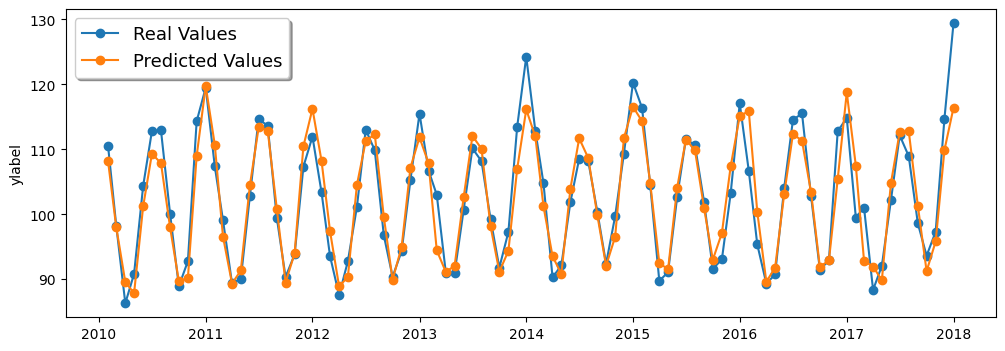

In [ ]:
import matplotlib.pyplot as plt

plt.figure( figsize= (12,4) )
plt.plot( df_test.index, df_test['values'], label = "Real Values" , marker = "o" )
plt.plot( df_test.index, df_test['pred'], label = "Predicted Values", marker = "o")
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()